In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

print(gym.__version__)

c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding enviro

0.21.0


In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        return self.fc2(x)


class TwoLayerFC(torch.nn.Module):
    # 这是一个简单的两层神经网络
    def __init__(self,
                 num_in,
                 num_out,
                 hidden_dim,
                 activation=F.relu,
                 out_fn=lambda x: x):
        super().__init__()
        self.fc1 = nn.Linear(num_in, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_out)

        self.activation = activation
        self.out_fn = out_fn

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.out_fn(self.fc3(x))
        return x

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, num_in_actor, num_out_actor, num_in_critic, hidden_dim,
                 discrete, action_bound, sigma, actor_lr, critic_lr, tau,
                 gamma, device):
        # self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        # self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        # self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        #* 输出全连接层的激活函数, discrete=true: 动作是离散的, discrete=false: 动作是连续的,输出连续动作
        out_fn = (lambda x: x) if discrete else (
            lambda x: torch.tanh(x) * action_bound)
        self.actor = TwoLayerFC(num_in_actor,
                                num_out_actor,
                                hidden_dim,
                                activation=F.relu,
                                out_fn=out_fn).to(device)
        self.target_actor = TwoLayerFC(num_in_actor,
                                       num_out_actor,
                                       hidden_dim,
                                       activation=F.relu,
                                       out_fn=out_fn).to(device)
        self.critic = TwoLayerFC(num_in_critic, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(num_in_critic, 1,
                                        hidden_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = num_out_actor
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(
            torch.cat(
                [next_states, self.target_actor(next_states)], dim=1))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(
            F.mse_loss(
                # MSE损失函数
                self.critic(torch.cat([states, actions], dim=1)),
                q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(
            self.critic(
                # 策略网络就是为了使得Q值最大化
                torch.cat([states, self.actor(states)], dim=1)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [4]:
actor_lr = 5e-4
critic_lr = 5e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1' ## 200步后游戏结束
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, action_dim, state_dim + action_dim, hidden_dim, False,
             action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

# Iteration 0: 100%|██████████| 20/20 [02:42<00:00,  8.11s/it, episode=20,
# return=-1269.365]
# Iteration 1: 100%|██████████| 20/20 [03:38<00:00, 10.94s/it, episode=40,
# return=-916.439]
# Iteration 2: 100%|██████████| 20/20 [03:38<00:00, 10.93s/it, episode=60,
# return=-450.922]
# Iteration 3: 100%|██████████| 20/20 [03:36<00:00, 10.81s/it, episode=80,
# return=-239.596]
# Iteration 4: 100%|██████████| 20/20 [03:37<00:00, 10.86s/it, episode=100,
# return=-173.360]
# Iteration 5: 100%|██████████| 20/20 [03:38<00:00, 10.91s/it, episode=120,
# return=-239.450]
# Iteration 6: 100%|██████████| 20/20 [03:38<00:00, 10.91s/it, episode=140,
# return=-184.360]
# Iteration 7: 100%|██████████| 20/20 [03:37<00:00, 10.88s/it, episode=160,
# return=-172.832]
# Iteration 8: 100%|██████████| 20/20 [03:38<00:00, 10.90s/it, episode=180,
# return=-178.041]
# Iteration 9: 100%|██████████| 20/20 [03:38<00:00, 10.91s/it, episode=200,
# return=-190.356]

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\37103\AppData\Local\Temp\ipykernel_12276\1541946690.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it, episode=200, return=-193.327]


In [ ]:
torch.save()

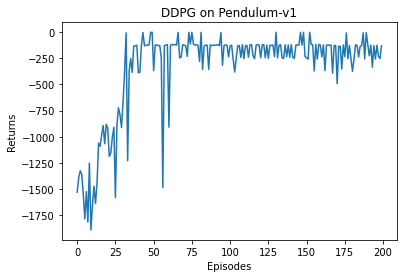

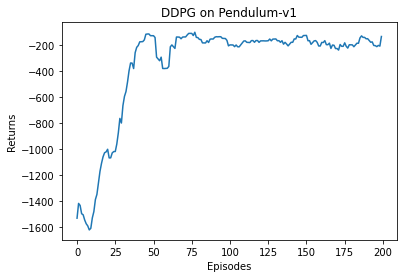

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

for i in range(len(episodes_list)):
    writer.add_scalar('return', return_list[i], episodes_list[i])

---